# Module 4 : Neural Networks with TensorFlow

이번 module에서는 TF를 이용해서 NN을 만들어보겠습니다. 앞서 module 3에서 estimator.DNNClassifier를 이용해 NN으로 classification 문제를 해결하긴 했는데, 이번에는 조금 더 자세한 부분까지 직접 조절할 수 있는 neural network입니다. 

이번 module은 다음 문서를 기반으로 만들어졌습니다.

https://www.tensorflow.org/tutorials/keras/classification

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Intro to NN

본 영상에서는 Keras 및 NN에 대해 꽤 많이 설명을 하고 있습니다. 각 neuron들이 어떻게 연결되어 있는지부터 layers, weight/bias, activation function, backpropagation, loss function, gradient descent, oprimizer까지 간단하게 짚어보고 구현으로 들어갑니다. 해당 내용을 다 싣기에는 현재 시간이 부족해서... 스킵하도록 하겠습니다. 추후 여견이 된다면 추가하도록 하겠습니다. [원작자의 colab notebook 링크](https://colab.research.google.com/drive/1m2cg3D1x3j5vrFc-Cu0gMvc48gWyCOuG#forceEdit=true&sandboxMode=true&scrollTo=-HJV4JF789aC)를 걸어둡니다.

## Dataset

이번 module에서는 Fashion-MNIST dataset을 사용합니다. 기존 MNIST가 흑백으로 된 숫자(0~9) 손글씨 데이터셋이라면, Fashion-MNIST는 10종류의 옷 이미지로 구성된 데이터셋입니다. Neural network를 이용해서 사진을 입력받아 이 옷이 어떤 종류인지 분류하는 문제를 해결하고자 합니다.

Training set에 포함된 이미지는 총 60000개이고, 각 이미지는 28x28 픽셀입니다. Test/validation set에는 10000개의 이미지가 있습니다.

텐서플로에서 이 데이터셋을 제공합니다. 

In [2]:
dataset = keras.datasets.fashion_mnist

(img_train, label_train), (img_test, label_test) = dataset.load_data()

Training set에 총 60000장의 이미지가 28x28 사이즈로 존재함을 알 수 있습니다. 각 픽셀값은 0~255 사이의 값이고, RGB 대신 흑백 이미지임을 확인할 수 있습니다.

In [3]:
print(img_train.shape)
print(img_train[0, 5])

(60000, 28, 28)
[  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
 144 123  23   0   0   0   0  12  10   0]


Label은 0~9 사이의 숫자로 이루어져 있습니다. 각 숫자가 한 class(옷 종류)를 의미한다고 보면 됩니다. 각 숫자가 어떤 옷을 의미하는지 보기 위해 class 이름을 정의합시다.

In [4]:
print(label_train[:5])

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

[9 0 0 3 0]


마지막으로 실제 이미지가 어떻게 생겼는지 확인해보도록 합시다. 각 픽셀이 가지는 값에 따라 어떤 색을 가지는지 colorbar로 확인할 수 있습니다.

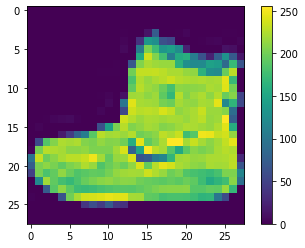

In [5]:
plt.imshow(img_train[0])
plt.colorbar()
plt.show()

## Data preprocessing

먼저 데이터 전처리를 진행합시다. 0-255의 값을 그대로 neural network에 집어넣어도 되지만 그 전에 모든 픽셀값을 0-1로 normalize해줍시다. Training set과 test set에 똑같이 적용합니다.

왜 이런 작업을 해 주는것이 중요한가...라고 물으신다면 간단하게 학습이 더 빨라지고, 더 괜찮게 converge할 수 있게 해 준다라고 이야기 할 것 같습니다. 지금이야 feature가 한 종류니까 그렇다쳐도 각 input 값들이 다른 scale을 가지게 된다면, 그리고 normalization을 하지 않는다면 특정 feature가 dominant하게 작용할 수도 있기 때문입니다.

영상에서는 weight, bias는 random하게 0-1사이로 정해지는데 input value와 mismatch가 일어나면 학습 단계에서 업데이트 시 문제가 생길 수 있다고 합니다.

당장 바로 아래 코드를 돌리고 NN 학습 후 결과를 보는 것과, 돌리지 않고 보는 것 사이에 4-5%의 차이가 생기는 것을 확인할 수 있습니다.

In [6]:
img_train = img_train/255.0
img_test = img_test/255.0

## Building NN model

이제 NN 모델을 만들어봅시다. Keras 덕분에 매우 쉽게, 코드 몇 줄 만으로 neural network를 구현할 수 있습니다.

Input layer, output layer, 그리고 hidden layer 1개로 구성된 neural network를 만들어봅시다. 이 모델은 fully connected network(FCN)입니다.

  - Input layer에서는 28x28 모양의 이미지를 1x784개로 펼칩니다. 그래서 각 픽셀이 neuron 1개에 대응될 수 있도록 해 줍니다. Input layer의 neuron 개수는 784개입니다.
  
  - Hidden layer의 neuron 개수는 128개입니다. Dense layer이기 때문에 이전 layer의 neuron들이 현재 layer의 neuron들과 모두 연결되어 있습니다. Activation function으로는 ReLU를 사용했습니다.
  
  - Output layer의 neuron 개수는 10개입니다. 마찬가지로 dense layer이고, 이제 neuron들은 10개의 class와 일대일 대응이 됩니다. Activation function으로 Softmax를 사용했기 때문에 neuron의 값이 해당 class일 확률이라고 생각할 수 있습니다.

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation = 'relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation = 'softmax') # output layer (3)
])

## Compile model

마지막으로 loss function과 optimizer, metric을 지정하면서 model을 compile해줍니다. 

In [8]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

## Training model

이제 model을 학습시켜봅시다. model.fit(data, label, epochs)으로 간단하게 모델을 학습시킬 수 있습니다. 매 epoch, 매 순간마다 학습 경과와 loss, accuracy를 출력해줍니다.

In [9]:
model.fit(img_train, label_train, epochs = 10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.5033 - accuracy: 0.8227
Epoch 2/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.3764 - accuracy: 0.8645
Epoch 3/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.3382 - accuracy: 0.8773
Epoch 4/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.3142 - accuracy: 0.8842
Epoch 5/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.2972 - accuracy: 0.8902
Epoch 6/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2819 - accuracy: 0.8965
Epoch 7/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2714 - accuracy: 0.8993
Epoch 8/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2596 - accuracy: 0.9029
Epoch 9/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2516 - accuracy: 0.9062
Epoch 10/10
60

## Validate model

학습시킨 모델이 test set에 대해서 얼마나 정확하게 작동하는지 확인해보도록 하겠습니다. 여기서 verbose라는 parameter가 등장하는데, 위에서 보여준 학습 과정 등을 출력할 지 말 지를 정하는 파라미터입니다. 0일 경우에 아무것도 출력하지 않고, 1일 경우에 위와 같이 progress bar를 보여줍니다.

In [10]:
loss, accuracy = model.evaluate(img_test, label_test, verbose=0) 

print('Test accuracy:', accuracy)

Test accuracy: 0.8847


약 88%의 정확도를 보여주네요. Training 과정에서의 정확도보다 test 과정에서의 정확도가 더 낮은데 이런 현상을 overfitting 현상이라고 합니다. 최악의 경우에는, 모델이 training set만 잘 맞추고 test set은 거의 맞추지 못하는 상황도 발생합니다. 

## Making prediction model

이제 test set에 있는 이미지를 예측하는 모델을 만들어봅시다. 0~1000 사이의 번호를 입력하면 test set에서 입력한 숫자에 해당하는 index의 이미지를 출력하면서 모델이 예측한 label과 실제 label을 출력합니다.

*plt.title, plt.xlabel이 출력되어야 하는데 현재 출력이 되지 않습니다.

Pick a number: 123


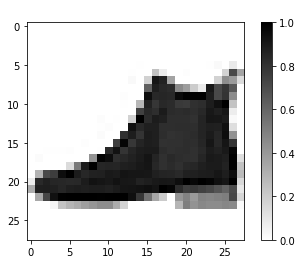

In [24]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    prediction = model.predict(np.array([image]))
    predicted_class = class_names[np.argmax(prediction)]

    show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
    plt.figure()
    plt.imshow(img, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.title("Excpected: " + label)
    plt.xlabel("Guess: " + guess)
    plt.show()   

def get_number():
    while True:
        num = input("Pick a number: ")
        if num.isdigit():
            num = int(num)
            if 0 <= num <= 1000:
                return int(num)
        else:
            print("Try again...")

num = get_number()
image = img_test[num]
label = label_test[num]
predict(model, image, label)


## Conclusion

매우 간단하게 neural network을 만들어보고, 이미지를 분류해보는 작업을 했습니다. 다음 module에서는 DNN보다 이미지 처리에 더 적합한 Convolutional neural network(CNN)에 대해 알아보도록 하겠습니다.